## Face Recognition Pipeline

Download the CelebA-HQ small subset
with annotations from here: https://tinyurl.com/
celebahqsmall.

In [543]:
CSV_FILE = '../data/CelebA-HQ-small.csv'
IMG_DIR = '../data/CelebA-HQ-small'

import pandas as pd

df = pd.read_csv(CSV_FILE)
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

print(f"Train test split: {len(train_df) / len(df):.2f}")

Train test split: 0.54


### 1. Face detection

- Use the Viola-Jones algorithm for face detection.
- Optimize its parameters for the best performance
on the training part of the dataset.
- Report detection metrics using Intersection over
Union (IoU).

In [544]:
import cv2
import numpy as np
import time


def iou(box_1, box_2):
    # bounding boxes in (x, y, w, h) format
    x1 = max(box_1[0], box_2[0])
    y1 = max(box_1[1], box_2[1])
    x2 = min(box_1[0] + box_1[2], box_2[0] + box_2[2])
    y2 = min(box_1[1] + box_1[3], box_2[1] + box_2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box_1_area = box_1[2] * box_1[3]
    box_2_area = box_2[2] * box_2[3]
    union = box_1_area + box_2_area - intersection

    if union != 0:
        return intersection / union
    else:
        return 0


class ViolaJonesDetector:
    def __init__(self):
        self.cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    def detect_face(self, image, scale_factor=1.1, min_neighbors=7, min_size=(20, 20)):  # optimal configuration
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.cascade.detectMultiScale(
            gray,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=min_size
        )

        if len(faces) == 0:
            return None
        else:
            return faces[0]

    def evaluate(self, dataframe, image_dir, scale_factor, min_neighbors, min_size):
        start_time = time.time()
        iou_scores = []
        for _, row in dataframe.iterrows():
            # read image
            image_idx = row['idx']
            image_path = f"{image_dir}/{image_idx}.jpg"
            image_box = (row['x_1'], row['y_1'], row['width'], row['height'])

            # detect face bounding box
            image = cv2.imread(image_path)
            detected_box = self.detect_face(
                image,
                scale_factor=scale_factor,
                min_neighbors=min_neighbors,
                min_size=min_size
            )

            if detected_box is not None:
                iou_scores.append(iou(detected_box, image_box))
            else:
                iou_scores.append(0.0)

        evaluation_time = time.time() - start_time
        return np.mean(iou_scores), evaluation_time


detector = ViolaJonesDetector()
# default configuration
scale_factor = 1.1
min_neighbors = 5
min_size = (30, 30)

# train_iou, eval_time = detector.evaluate(train_df, IMG_DIR, scale_factor, min_neighbors, min_size)
# print(f"IoU score: {train_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

```txt
IoU score: 0.654, evaluation time: 24.325 seconds
```

Parameter grid search

In [545]:
def viola_grid_search():
    scale_factor_values = [1.05, 1.1, 1.2]
    min_neighbors_values = [3, 5, 7]
    min_size_values = [(20, 20), (30, 30), (40, 40)]

    best_iou = 0
    best_config = None
    for scale_factor in scale_factor_values:
        for min_neighbors in min_neighbors_values:
            for min_size in min_size_values:
                train_iou, eval_time = detector.evaluate(train_df, IMG_DIR, scale_factor, min_neighbors, min_size)
                if train_iou > best_iou:
                    best_iou = train_iou
                    best_config = {'scale_factor': scale_factor,
                                   'min_neighbors': min_neighbors,
                                   'min_size': min_size}
                print(
                    f"Config: scale_factor={scale_factor}, min_neighbors={min_neighbors}, min_size={min_size} => Result: IoU={train_iou:.3f}, eval_time={eval_time:.3f}s")
    return best_config, best_iou

# best_config, best_iou = viola_grid_search()
# print(f"Best config: {best_config}, IoU score: {best_iou:.3f}")

```text
Config: scale_factor=1.05, min_neighbors=3, min_size=(20, 20) => Result: IoU=0.586, eval_time=63.286s
Config: scale_factor=1.05, min_neighbors=3, min_size=(30, 30) => Result: IoU=0.625, eval_time=50.953s
Config: scale_factor=1.05, min_neighbors=3, min_size=(40, 40) => Result: IoU=0.629, eval_time=45.876s
Config: scale_factor=1.05, min_neighbors=5, min_size=(20, 20) => Result: IoU=0.641, eval_time=62.373s
Config: scale_factor=1.05, min_neighbors=5, min_size=(30, 30) => Result: IoU=0.650, eval_time=51.126s
Config: scale_factor=1.05, min_neighbors=5, min_size=(40, 40) => Result: IoU=0.653, eval_time=44.953s
Config: scale_factor=1.05, min_neighbors=7, min_size=(20, 20) => Result: IoU=0.659, eval_time=63.365s
Config: scale_factor=1.05, min_neighbors=7, min_size=(30, 30) => Result: IoU=0.667, eval_time=51.343s
Config: scale_factor=1.05, min_neighbors=7, min_size=(40, 40) => Result: IoU=0.657, eval_time=45.393s
Config: scale_factor=1.1, min_neighbors=3, min_size=(20, 20) => Result: IoU=0.642, eval_time=33.318s
Config: scale_factor=1.1, min_neighbors=3, min_size=(30, 30) => Result: IoU=0.645, eval_time=24.989s
Config: scale_factor=1.1, min_neighbors=3, min_size=(40, 40) => Result: IoU=0.650, eval_time=22.772s
Config: scale_factor=1.1, min_neighbors=5, min_size=(20, 20) => Result: IoU=0.664, eval_time=33.407s
Config: scale_factor=1.1, min_neighbors=5, min_size=(30, 30) => Result: IoU=0.652, eval_time=26.895s
Config: scale_factor=1.1, min_neighbors=5, min_size=(40, 40) => Result: IoU=0.663, eval_time=25.873s
Config: scale_factor=1.1, min_neighbors=7, min_size=(20, 20) => Result: IoU=0.673, eval_time=33.752s
Config: scale_factor=1.1, min_neighbors=7, min_size=(30, 30) => Result: IoU=0.664, eval_time=26.332s
Config: scale_factor=1.1, min_neighbors=7, min_size=(40, 40) => Result: IoU=0.669, eval_time=24.015s
Config: scale_factor=1.2, min_neighbors=3, min_size=(20, 20) => Result: IoU=0.665, eval_time=19.902s
Config: scale_factor=1.2, min_neighbors=3, min_size=(30, 30) => Result: IoU=0.661, eval_time=15.930s
Config: scale_factor=1.2, min_neighbors=3, min_size=(40, 40) => Result: IoU=0.663, eval_time=15.374s
Config: scale_factor=1.2, min_neighbors=5, min_size=(20, 20) => Result: IoU=0.666, eval_time=20.155s
Config: scale_factor=1.2, min_neighbors=5, min_size=(30, 30) => Result: IoU=0.667, eval_time=15.990s
Config: scale_factor=1.2, min_neighbors=5, min_size=(40, 40) => Result: IoU=0.667, eval_time=15.180s
Config: scale_factor=1.2, min_neighbors=7, min_size=(20, 20) => Result: IoU=0.657, eval_time=20.142s
Config: scale_factor=1.2, min_neighbors=7, min_size=(30, 30) => Result: IoU=0.656, eval_time=15.957s
Config: scale_factor=1.2, min_neighbors=7, min_size=(40, 40) => Result: IoU=0.656, eval_time=15.353s
Best config: {'scale_factor': 1.1, 'min_neighbors': 7, 'min_size': (20, 20)}, IoU score: 0.673
```

### 2. Feature extraction

- Select and implement at least three feature
extraction methods for face recognition. You may
Fig. 1. Example of face detection during November.
use implementations available in popular libraries
(e.g., Scikit-learn, OpenCV).
-  Probably the easiest to use methods:
    - Local Binary Patterns (LBP),
    - Histogram of Oriented Gradients (HOG),
    - Dense SIFT (using a fixed grid instead of
keypoint detectors).

In [546]:
import os
from skimage.feature import local_binary_pattern


# Local Binary Patterns
class LBPExtractor:
    def __init__(self, n_neighbors=24, radius=3):
        self.n_neighbors = n_neighbors
        self.radius = radius

    def extract(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, self.n_neighbors, self.radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, self.n_neighbors + 3),
                               range=(0, self.n_neighbors + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-10)
        return hist

    # chi square distance
    def compare(self, features_1, features_2):
        return 0.5 * np.sum(((features_1 - features_2) ** 2) / (features_1 + features_2 + 1e-10))


# compute rank-1 and rank-5 accuracy
def evaluate_extractor(extractor, dataframe, image_dir, save_dir, detector=None):
    start_time = time.time()
    features = []
    labels = []

    for _, row in dataframe.iterrows():
        try:
            image_idx = row['idx']
            image_path = f"{image_dir}/{image_idx}.jpg"
            image = cv2.imread(image_path)

            if detector is not None:
                detected_box = detector.detect_face(image)
                if detected_box is not None:
                    # crop image
                    x, y, w, h = detected_box
                    image = image[y:y + h, x:x + w]

            features.append(extractor.extract(image))
            labels.append(row['identity'])
        except Exception as error:
            print(error)
            continue

    features = np.array(features)
    labels = np.array(labels)
    n_images = len(features)
    rank_1_correct = 0
    rank_5_correct = 0
    distance_matrix = np.zeros((n_images, n_images))

    # compute distances
    for i in range(n_images):
        distance_matrix[i, i] = np.inf  # distance to self
        for j in range(i + 1, n_images):
            distance = extractor.compare(features[i], features[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    # save labels and distance matrix as txt
    os.makedirs(save_dir, exist_ok=True)
    np.savetxt(f"{save_dir}/distance_matrix.txt", distance_matrix)
    np.savetxt(f"{save_dir}/labels.txt", labels, fmt='%s')

    # compute accuracy
    for i in range(n_images):
        sorted_indices = np.argsort(distance_matrix[i])
        sorted_labels = labels[sorted_indices]
        if labels[i] == sorted_labels[0]:
            rank_1_correct += 1
        if labels[i] in sorted_labels[:5]:
            rank_5_correct += 1
    rank_1_acc = rank_1_correct / n_images
    rank_5_acc = rank_5_correct / n_images
    evaluation_time = time.time() - start_time
    return rank_1_acc, rank_5_acc, evaluation_time


lbp_extractor = LBPExtractor()

# rank1_acc, rank5_acc, eval_time = evaluate_extractor(lbp_extractor, test_df, IMG_DIR, '../out/lbp')
# print(f"LBP Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")
#
# rank1_acc, rank5_acc, eval_time = evaluate_extractor(lbp_extractor, test_df, IMG_DIR, '../out/lbpd', detector=detector)
# print(f"With Detector: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

```text
LBP Extractor: rank_1_acc=0.141, rank_5_acc=0.311, eval_time=163.021s
With Detector: rank_1_acc=0.177, rank_5_acc=0.342, eval_time=98.897s
```

### 3. Evaluation through three experiments:
- Evaluate detection performance separately
and report IoU metrics.
- Evaluate recognition performance. Report Rank-1 and Rank-5 recognition accuracies:
    - Whole images using each feature extractor,
    - The full pipeline (Viola-Jones for detection followed by each feature extractor).

Original images are 1024x1024 pixels

In [547]:
# Histogram of Oriented Gradients
from skimage.feature import hog


class HOGExtractor:
    def __init__(self, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.orientations = orientations

    def extract(self, image):
        resized = cv2.resize(image, (256, 256))  # downsize for efficiency
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        hog_features = hog(gray,
                           orientations=self.orientations,
                           pixels_per_cell=self.pixels_per_cell,
                           cells_per_block=self.cells_per_block,
                           block_norm='L2-Hys')
        return hog_features

    # chi square distance
    def compare(self, features_1, features_2):
        return 0.5 * np.sum(((features_1 - features_2) ** 2) / (features_1 + features_2 + 1e-10))


hog_extractor = HOGExtractor()

# rank1_acc, rank5_acc, eval_time = evaluate_extractor(hog_extractor, test_df, IMG_DIR, '../out/hog')
# print(f"HOG Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")
#
# rank1_acc, rank5_acc, eval_time = evaluate_extractor(hog_extractor, test_df, IMG_DIR, '../out/hogd', detector=detector)
# print(f"With Detector: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

```text
HOG Extractor: rank_1_acc=0.342, rank_5_acc=0.541, eval_time=19.642s
With Detector: rank_1_acc=0.335, rank_5_acc=0.546, eval_time=45.367s
```

In [548]:
# Dense SIFT using a fixed grid
class SIFTExtractor:
    def __init__(self, step_size=8, bin_size=16):
        self.step_size = step_size
        self.bin_size = bin_size
        self.sift = cv2.SIFT_create()

    def extract(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # dense keypoint grid
        keypoints = [
            cv2.KeyPoint(x, y, self.bin_size)
            for y in range(0, gray.shape[0], self.step_size)
            for x in range(0, gray.shape[1], self.step_size)
        ]

        _, descriptors = self.sift.compute(gray, keypoints)
        if descriptors is None:
            return np.zeros((128,), dtype=np.float32)
        else:
            # mean pooling
            features = descriptors.mean(axis=0)
            features = features.astype(np.float32)
            features /= (np.linalg.norm(features) + 1e-10)
            return features

    # euclidean distance
    def compare(self, features_1, features_2):
        return np.linalg.norm(features_1 - features_2)


sift_extractor = SIFTExtractor()

# rank1_acc, rank5_acc, eval_time = evaluate_extractor(sift_extractor, test_df, IMG_DIR, '../out/sift')
# print(f"SIFT Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")
#
# rank1_acc, rank5_acc, eval_time = evaluate_extractor(sift_extractor, test_df, IMG_DIR, '../out/siftd',
#                                                      detector=detector)
# print(f"With Detector: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

```text
SIFT Extractor: rank_1_acc=0.148, rank_5_acc=0.282, eval_time=195.205s
With Detector: rank_1_acc=0.182, rank_5_acc=0.371, eval_time=108.219s
```

Plot Cumulative Match Characteristic (CMC) curves

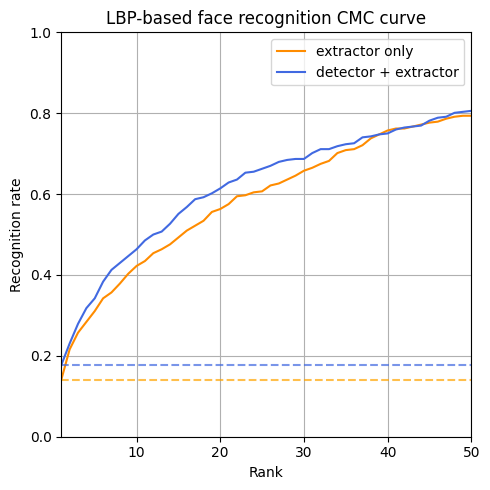

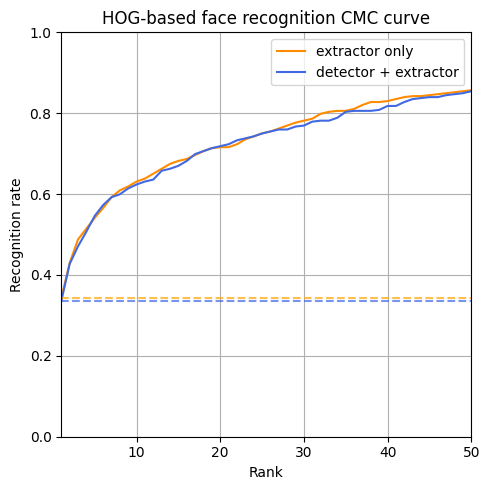

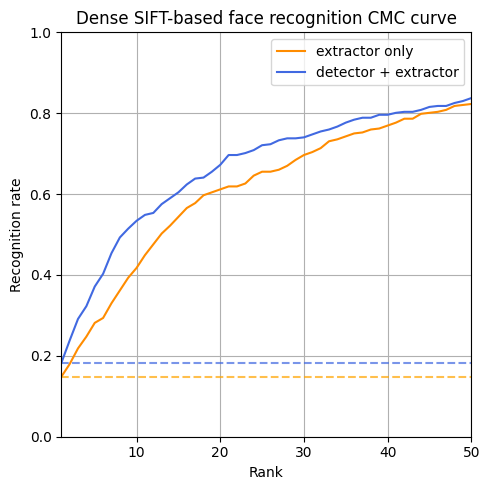

In [549]:
import os
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = '../out'
PLOT_DIR = '../plot'


def calculate_cmc(distance_matrix, labels):
    n_images = len(labels)
    cmc = np.zeros(n_images)
    for i in range(n_images):
        sorted_indices = np.argsort(distance_matrix[i])
        sorted_labels = labels[sorted_indices]

        # find first match
        rank_of_match = np.where(sorted_labels == labels[i])[0][0]

        # increment ranks <=
        cmc[rank_of_match:] += 1

    # normalize
    cmc /= n_images
    return cmc


def plot_cmc_curve_pair(feature_extractor, title):
    distances = np.loadtxt(f"{OUT_DIR}/{feature_extractor}/distance_matrix.txt")
    labels = np.loadtxt(f"{OUT_DIR}/{feature_extractor}/labels.txt", dtype=str)
    n_images = len(labels)

    distances_detector = np.loadtxt(f"{OUT_DIR}/{feature_extractor}d/distance_matrix.txt")
    labels_detector = np.loadtxt(f"{OUT_DIR}/{feature_extractor}d/labels.txt", dtype=str)
    n_images_detector = len(labels_detector)

    # sanity check
    assert n_images == n_images_detector

    cmc = calculate_cmc(distances, labels)
    cmc_detector = calculate_cmc(distances_detector, labels_detector)

    # plot both curves
    os.makedirs(PLOT_DIR, exist_ok=True)

    plt.figure(figsize=(5, 5))
    plt.plot(range(1, n_images + 1), cmc, label="extractor only", color="darkorange")
    plt.plot(range(1, n_images + 1), cmc_detector, label="detector + extractor", color="royalblue")

    # mark rank-1 accuracies with dashed lines
    plt.axhline(y=cmc[0], color="orange", linestyle="--", alpha=0.7)
    plt.axhline(y=cmc_detector[0], color="royalblue", linestyle="--", alpha=0.7)

    plt.xlabel("Rank")
    plt.ylabel("Recognition rate")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.xlim([1, 50])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig(f"{PLOT_DIR}/{feature_extractor}_cmc_curve.png")
    plt.show()


plot_cmc_curve_pair("lbp", "LBP-based face recognition CMC curve")
plot_cmc_curve_pair("hog", "HOG-based face recognition CMC curve")
plot_cmc_curve_pair("sift", "Dense SIFT-based face recognition CMC curve")

In [550]:
# test_iou, eval_time = detector.evaluate(test_df, IMG_DIR, 1.1, 7, (20, 20))
# print(f"IoU score: {test_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

```text
IoU score: 0.653, evaluation time: 29.332 seconds
```